IMPORTING LIBRARIES

In [299]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

IMPORTING DATA


In [300]:
import pandas as pd
stock_data = pd.read_csv('MOTH.csv', index_col='Date')
stock_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-30,85.900002,86.400002,85.300003,85.699997,85.118523,10846744
2023-07-03,86.300003,86.400002,85.300003,86.099998,85.515816,6238291
2023-07-04,86.500000,86.500000,84.800003,85.150002,84.572258,7104307
2023-07-05,91.000000,93.650002,88.650002,90.300003,89.687317,60717634
2023-07-06,90.849998,92.900002,90.000000,91.550003,90.928841,21908735


In [301]:
stock_data['Open-Close'] = stock_data.Open - stock_data.Close
stock_data['High-Low'] = stock_data.High - stock_data.Low


# Store all predictor variables in a variable X
XN = stock_data[['Open-Close', 'High-Low']]
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(XN.iloc[:, 1:3])
XN.iloc[:, 1:3] = imputer.transform(XN.iloc[:, 1:3])



X= XN.round(2)
X

,Open-Close,High-Low
Date,,
2023-06-30,0.20,1.10
2023-07-03,0.20,1.10
2023-07-04,1.35,1.70
2023-07-05,0.70,5.00
2023-07-06,-0.70,2.90
...,...,...
2024-06-24,-1.20,7.38
2024-06-25,-4.34,6.22
2024-06-26,-1.55,5.78


PLOTTING GRAPHS

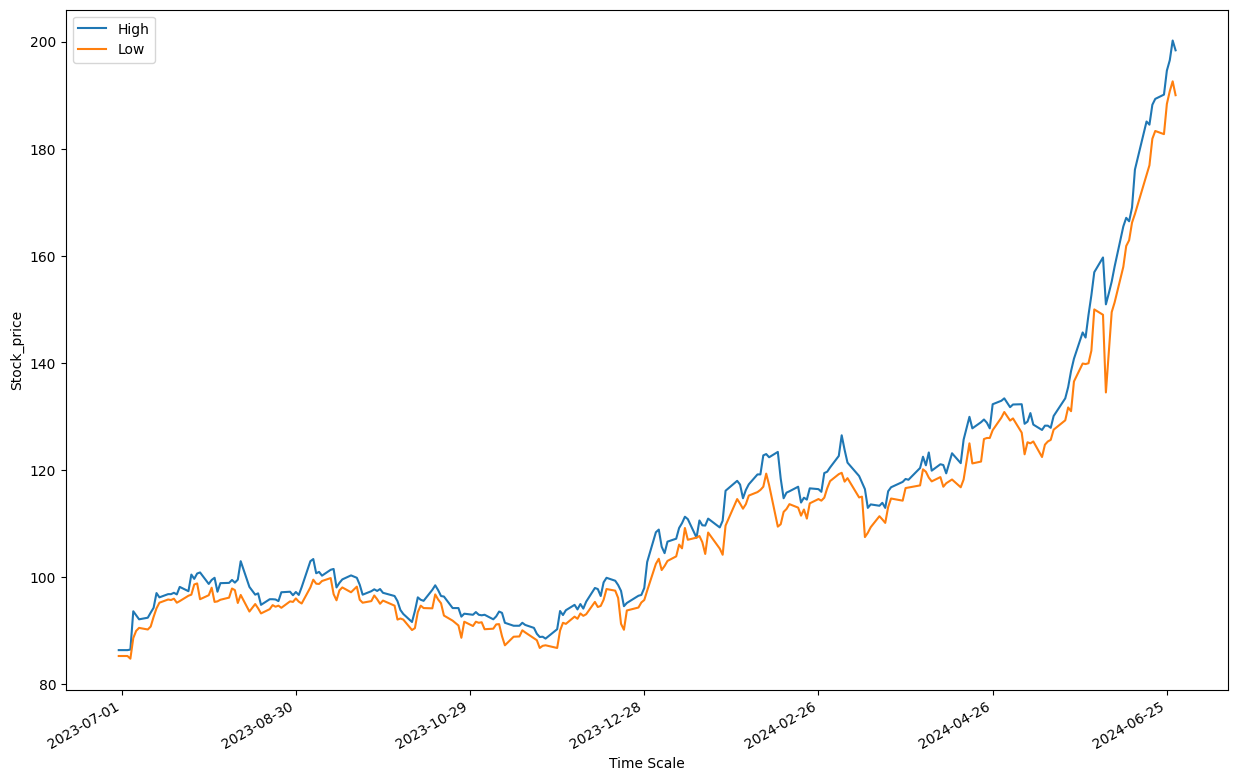

In [302]:


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter (mdates.DateFormatter ('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator (mdates. DayLocator (interval=60))
x_dates=[dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Stock_price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

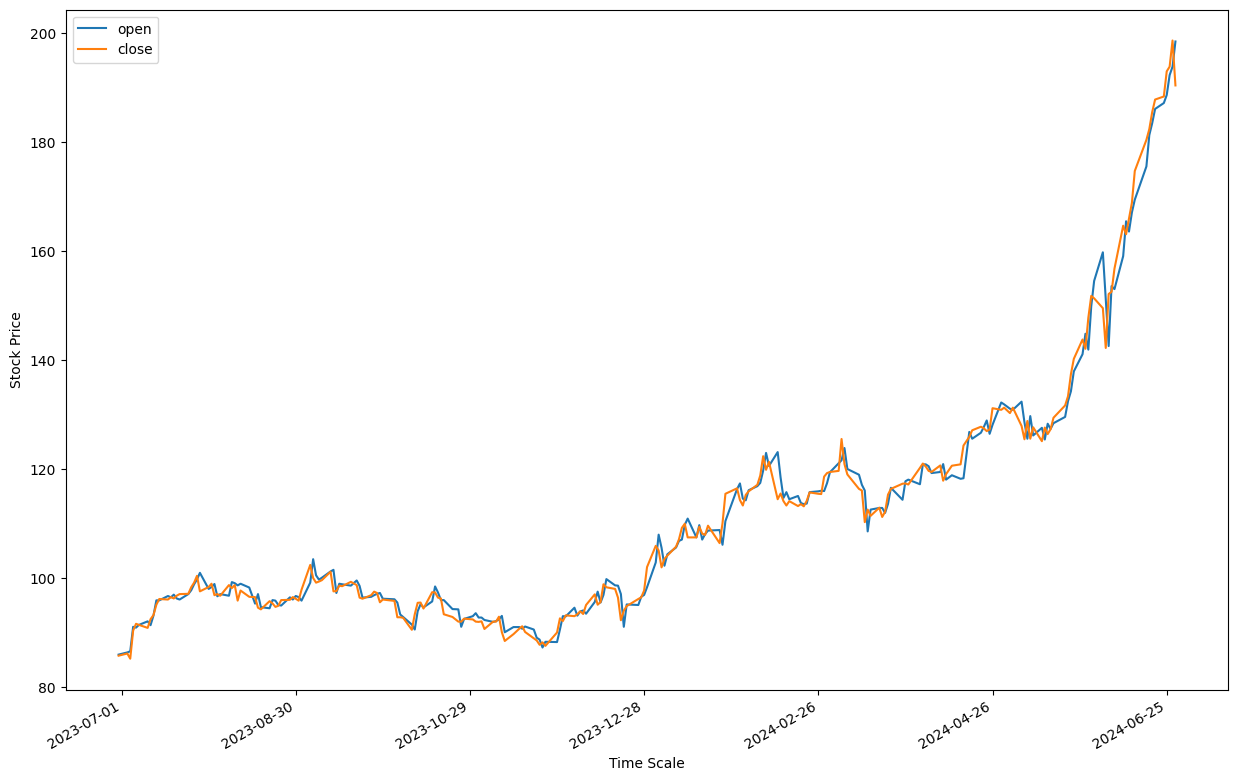

In [303]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter (mdates.DateFormatter ('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator (mdates. DayLocator (interval=60))
x_dates=[dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
plt.plot(x_dates, stock_data['Open'], label='open')
plt.plot(x_dates, stock_data['Close'], label='close')
plt.xlabel('Time Scale')
plt.ylabel('Stock Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

DATA PREPROCESSING

In [304]:
y = stock_data['Close']
X_feat =stock_data.iloc[:,0:3]

In [305]:
#Feature Scaling
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,
                    data=X_ft,
                    index=X_feat.index)



LSTM Train test split

In [306]:
def lstm_split(data, n_steps):
  X, y = [],[]
  for i in range(len(data) -n_steps+1):
    X.append(data[i:i + n_steps, :])  # Reshape to 2D
    y.append(data[i+n_steps-1, -1])
  return np.array(X), np.array(y)


In [307]:

X1, y1 = lstm_split(X_ft.values, n_steps=1)
train_split=0.8
split_idx= int(np.ceil((len(X1))*train_split))
date_index = X_ft.index

x_train, x_test= X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
x_train_date, x_test_date = date_index[:split_idx], date_index [split_idx:]
print (X1.shape, x_train.shape, x_test.shape, y_test.shape)


(244, 1, 3) (196, 1, 3) (48, 1, 3) (48,)


In [308]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]) , activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1, 50)             10800     
                                                                 
 dense_29 (Dense)            (None, 1, 1)              51        
                                                                 
Total params: 10851 (42.39 KB)
Trainable params: 10851 (42.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [309]:
history =lstm.fit(x_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle = False)

Epoch 1/100
49/49 - 1s - loss: 0.2874 - 1s/epoch - 30ms/step
Epoch 2/100
49/49 - 0s - loss: 0.1522 - 89ms/epoch - 2ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0548 - 80ms/epoch - 2ms/step
Epoch 4/100
49/49 - 0s - loss: 0.0193 - 78ms/epoch - 2ms/step
Epoch 5/100
49/49 - 0s - loss: 0.0123 - 71ms/epoch - 1ms/step
Epoch 6/100
49/49 - 0s - loss: 0.0095 - 90ms/epoch - 2ms/step
Epoch 7/100
49/49 - 0s - loss: 0.0087 - 74ms/epoch - 2ms/step
Epoch 8/100
49/49 - 0s - loss: 0.0086 - 66ms/epoch - 1ms/step
Epoch 9/100
49/49 - 0s - loss: 0.0086 - 79ms/epoch - 2ms/step
Epoch 10/100
49/49 - 0s - loss: 0.0086 - 85ms/epoch - 2ms/step
Epoch 11/100
49/49 - 0s - loss: 0.0086 - 63ms/epoch - 1ms/step
Epoch 12/100
49/49 - 0s - loss: 0.0086 - 76ms/epoch - 2ms/step
Epoch 13/100
49/49 - 0s - loss: 0.0086 - 74ms/epoch - 2ms/step
Epoch 14/100
49/49 - 0s - loss: 0.0086 - 111ms/epoch - 2ms/step
Epoch 15/100
49/49 - 0s - loss: 0.0086 - 95ms/epoch - 2ms/step
Epoch 16/100
49/49 - 0s - loss: 0.0086 - 71ms/epoch - 1ms/step
E

In [2]:
# Assuming necessary libraries are already imported (e.g., numpy, pandas, sklearn, tensorflow/keras)
!pip install scikeras

!pip install tensorflow

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# 1. Hyperparameter Tuning:

# Define a wider range of hyperparameters to explore:
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100, 150],
    'batch_size': [16, 32, 64]
}

# Use GridSearchCV or RandomSearchCV to find the best combination:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(units=64, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)  # Adjust cv as needed
grid_result = grid.fit(x_train, y_train)

# Print the best parameters found:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 2. Stacked LSTM Layers:

# Add more LSTM layers to capture complex temporal dependencies:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 3. Bidirectional LSTM:

# Capture information from both past and future contexts:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. Attention Mechanism:

# Focus on relevant parts of the input sequence:
!pip install attention
from attention import Attention

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Attention())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 5. Feature Engineering:

# Add more relevant features to the input data, such as:
# - Technical indicators (e.g., moving averages, RSI, MACD)
# - Fundamental data (e.g., company earnings, news sentiment)

# 6. Regularization:

# Use L1/L2 regularization to prevent overfitting:
from keras.regularizers import l2
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 7. Early Stopping:

# Stop training when the model's performance on a validation set stops improving:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# 8. Evaluate and Iterate:

# After trying these techniques, evaluate the model's performance using appropriate metrics (RMSE, MAPE, etc.).
# Iterate on the model architecture and hyperparameters based on the evaluation results.


  Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
y_pred=lstm.predict(x_test)

y_test=y_test.reshape(-1,1)


In [ ]:
import numpy as np

# Assuming y_test and y_pred are already defined as in your previous code

# Reshape y_pred to have 2 dimensions
y_pred = y_pred.reshape(y_test.shape) # Reshape y_pred to match y_test

# Concatenate y_test and y_pred horizontally
result = np.column_stack((y_test, y_pred))

print(result)

In [1]:
y_pred=lstm.predict(x_test)
y_pred = y_pred.reshape(-1)  # Reshape to 1D
# Extract the last prediction for each sequence
y_pred_all = y_pred[1::2]  # Select every other element starting from the second

# Adjust y_test to match the number of predictions
y_test_adj = y_test[1::2] # Select every other element starting from the second to match y_pred

rsme = mean_squared_error(y_test_adj, y_pred_all, squared=False)
mape =mean_absolute_percentage_error(y_test_adj, y_pred_all)
print("RMSE: ", rsme)
print("MAPE: ", mape)

NameError: name 'lstm' is not defined

In [ ]:
# prompt: inverse transform y test and y pred and plot their graph

# Assuming 'sc' was fitted on 3 features, reshape y_test and y_pred accordingly
y_test_reshaped = y_test.reshape(-1, 3)  # Reshape to (num_samples, 3)
y_pred_reshaped = y_pred.reshape(-1, 3)  # Reshape to (num_samples, 3)

# Inverse transform the y_test and y_pred values
y_test_inverse = sc.inverse_transform(y_test_reshaped)
y_pred_inverse = sc.inverse_transform(y_pred_reshaped)

# Create a new DataFrame to store the inverse transformed values
result_df = pd.DataFrame({
    'Actual': y_test_inverse.flatten(),  # Flatten to 1D for plotting
    'Predicted': y_pred_inverse.flatten()
})

# Plot the actual and predicted values
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in x_test_date]
plt.plot(x_dates, result_df['Actual'], label='Actual')
plt.plot(x_dates, result_df['Predicted'], label='Predicted')
plt.xlabel('Time Scale')
plt.ylabel('Stock Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

graph

ing deeper LSTM model(chnging units per layer to 32)

In [ ]:
lstm = Sequential()
lstm.add(LSTM(units=32, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]) , activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

In [ ]:
history =lstm.fit(x_train, y_train, epochs=100, batch_size=2, verbose=2, shuffle = False)

In [ ]:
# Reshape y_pred to have the original number of features (assumed to be 3)
y_pred = y_pred.reshape(-1, 3)
y_pred = sc.inverse_transform(y_pred)
# Reshape y_pred back to (48, 1) if needed
y_pred = y_pred[:, 0].reshape(-1, 1)
y_test = sc.inverse_transform(y_test.reshape(-1, 3))
y_test = y_test[:, 0]  # Extract the first column (assuming it's the target variable)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
rsme = mean_squared_error(y_test, y_pred, squared=False)
mape =mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ", rsme)
print("MAPE: ", mape)

trying with different n_steps
